In [1]:
import math
import numpy
import torch
import torchaudio
torchaudio.set_audio_backend("soundfile")
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
loadedData = torchaudio.load("a_a_i_a_u_e_a.wav")
tensor = loadedData[0][0]
sampleRate = loadedData[1]
del loadedData

In [3]:
"""
transformedTensor = torch.stft(tensor, 8129, hop_length = 8129, win_length = 8129, return_complex = True)
backTransformedTensor = torch.istft(transformedTensor, 8129, hop_length = 8129, win_length = 8129, length = 1036800)
torchaudio.save("output.wav", backTransformedTensor, sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)
difference = backTransformedTensor - tensor
error = difference/tensor
error = error * torch.isfinite(error)
error = torch.nan_to_num(error)
Amplitudes = transformedTensor.abs()
Phases = transformedTensor.angle()
Element = Amplitudes[0].transpose(0,1)[40]
maximum = torch.max(Element, 0)
height = maximum.values.item()
center = maximum.indices.item()
"""

'\ntransformedTensor = torch.stft(tensor, 8129, hop_length = 8129, win_length = 8129, return_complex = True)\nbackTransformedTensor = torch.istft(transformedTensor, 8129, hop_length = 8129, win_length = 8129, length = 1036800)\ntorchaudio.save("output.wav", backTransformedTensor, sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)\ndifference = backTransformedTensor - tensor\nerror = difference/tensor\nerror = error * torch.isfinite(error)\nerror = torch.nan_to_num(error)\nAmplitudes = transformedTensor.abs()\nPhases = transformedTensor.angle()\nElement = Amplitudes[0].transpose(0,1)[40]\nmaximum = torch.max(Element, 0)\nheight = maximum.values.item()\ncenter = maximum.indices.item()\n'

In [4]:
pitchTensor = torchaudio.functional.detect_pitch_frequency(tensor, sampleRate, frame_time = 0.01, win_length = 3, freq_low = 85, freq_high = 1000)

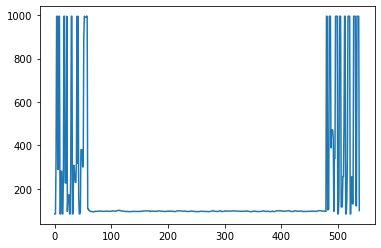

In [5]:
plt.plot(pitchTensor)

In [6]:
expectedPitch = 95.
searchRange = 0.2
batchSize = math.floor((1. + searchRange) * sampleRate / expectedPitch)
lowerSearchLimit = math.floor((1. - searchRange) * sampleRate / expectedPitch)

In [7]:
batchStart = 0
deltas = torch.tensor([], dtype = int)
while batchStart + batchSize <= tensor.size()[0]:
    
    sample = torch.index_select(tensor, 0, torch.linspace(batchStart, batchStart + batchSize, batchSize, dtype = int))
    zeroTransitions = torch.tensor([], dtype = int)
    for i in range(lowerSearchLimit, batchSize):
        if (sample[i-1] < 0) and (sample[i] > 0):
            zeroTransitions = torch.cat([zeroTransitions, torch.tensor([i])], 0)
            
    error = math.inf
    delta = math.floor(sampleRate / expectedPitch)
    for i in zeroTransitions:
        shiftedSample = torch.index_select(tensor, 0, torch.linspace(batchStart + i.item(), batchStart + batchSize + i.item(), batchSize, dtype = int))
        newError = torch.sum(torch.pow(sample - shiftedSample, 2))
        if error > newError:
            delta = i.item()
            error = newError
            
    deltas = torch.cat([deltas, torch.tensor([delta])])
    batchStart += delta

In [8]:
nBatches = deltas.size()[0]
borders = torch.zeros(nBatches + 1, dtype = int)
for i in range(nBatches):
    borders[i+1] = borders[i] + deltas[i]

In [60]:
Spectrums = torch.zeros(nBatches-2, torch.max(deltas))
Excitations = torch.zeros(nBatches-2, torch.max(deltas), dtype = torch.complex64)
for i in range(1, nBatches-1):
    lowerBorder = borders[i]
    upperBorder = borders[i+1]
    Window = torch.hann_window((upperBorder-lowerBorder) * 3)
    sample = torch.index_select(tensor, 0, torch.linspace(2 * lowerBorder - upperBorder, 2 * upperBorder - lowerBorder, 3 * (upperBorder-lowerBorder)).int())
    sample = Window * sample
    sample = torch.pow(torch.fft.fft(sample, n = torch.max(deltas)).abs(), 2)
    Spectrums[i-1] = (sample + torch.roll(sample, 1) + torch.roll(sample, -1))/3
    batch = torch.index_select(tensor, 0, torch.linspace(lowerBorder, upperBorder, upperBorder-lowerBorder).int())
    Excitations[i-1] = torch.fft.fft(batch, n = torch.max(deltas)) / Spectrums[i-1]

C:\ProgramData\Anaconda3\lib\site-packages\torch\tensor.py:623: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


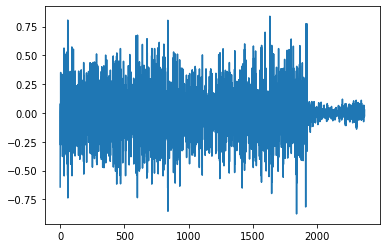

In [62]:
plt.plot(torch.fft.ifft(Excitations[100]))